In [1]:
# Importando Librerias

import pandas as pd
import os, string, unicodedata, re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.util import ngrams
import nltk
from tensorflow.keras.utils import to_categorical
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE



# Leyendo los archivos

In [2]:
df_csv =  pd.read_csv('informacion_roles_actualizado.csv')

df_clasificador = pd.read_excel('CLASIFICADO_FINAL.xlsx')

In [3]:
df_csv.head()

,rol,corte,fecha,folio,tramite,descripcion,fecha_ingreso
0,144280-2022,Valparaíso,05/02/2024,26.0,Actuación,COMUNICA CÚMPLASE CS,31/10/2022
1,144280-2022,Valparaíso,05/02/2024,25.0,Actuación,COMUNICA CÚMPLASE CS,31/10/2022
2,144280-2022,Valparaíso,05/02/2024,24.0,Resolución,Cúmplase CS,31/10/2022
3,144280-2022,Valparaíso,05/12/2023,23.0,Escrito,Recurso fallado Corte Suprema,31/10/2022
4,144280-2022,Valparaíso,15/06/2023,22.0,Resolución,(NMV)Concede Recurso (Intercon,31/10/2022


In [4]:
df_clasificador.head()

,Unnamed: 0,Descripcion,CLASIFICACION_FINAL
0,1461,Cumple lo ordenado / En Relaci,Téngase presente
1,202,Rec.Prot/D.cta.ONI.Sala Isapre,Dese cuenta
2,200,Cumple previo/Admisible GES,Admisibles
3,2621,Cambio código a masivo,ICA informa
4,1095,ocúrrase donde corresonda,ICA informa


In [5]:
df_clasificador['CLASIFICACION_FINAL'] = df_clasificador['CLASIFICACION_FINAL'].str.title()

In [6]:
df_clasificador['CLASIFICACION_FINAL'].value_counts()



CLASIFICACION_FINAL
Ica Solicita Diligencia    379
Agréguese A Tabla          319
Ica Informa                289
Evacua Informe             287
Admisibles                 255
Téngase Presente           203
Dese Cuenta                164
Apercibe                   160
Ica Amplia Plazo           138
Nhl                        119
Acoge                       69
Concede Apelación           54
Acuerdo                     43
Certifiquese                39
Cs                          38
Rechazada                   31
Art / Numeral               25
Archivado                   24
Fija Costas                 22
Inhabilidad                 22
Acumulación                 19
Oni                         17
Inadmisible/Omite           13
Prescinde                   13
Incompetencia               12
Multa                        7
Fallo/Desestima              5
Retira                       4
Inicio Tramitación           4
Name: count, dtype: int64

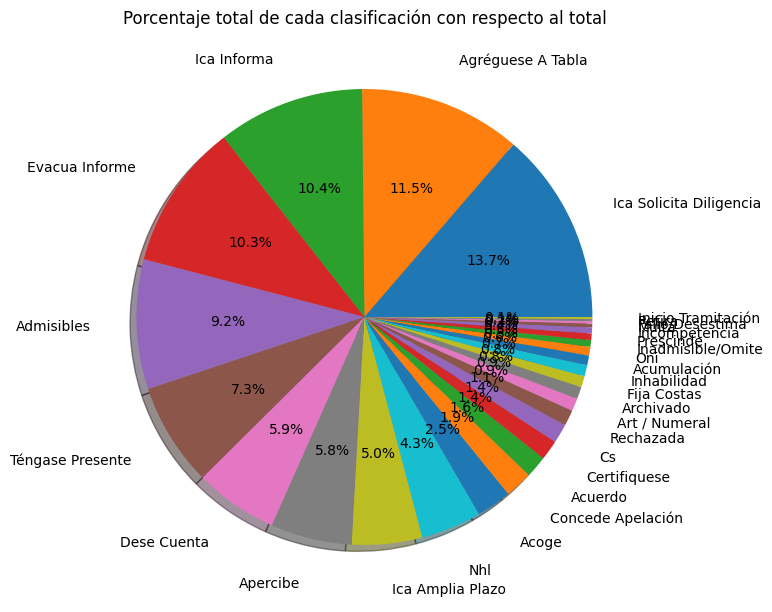

In [7]:
plt.figure(figsize=(10, 6))
plt.pie(df_clasificador['CLASIFICACION_FINAL'].value_counts(), labels=df_clasificador['CLASIFICACION_FINAL'].value_counts().index, autopct='%1.1f%%', labeldistance=1.2, normalize=True, shadow=True)
plt.tight_layout()
plt.title('Porcentaje total de cada clasificación con respecto al total')
plt.show()

In [8]:
dict_to_replace = df_clasificador.groupby('CLASIFICACION_FINAL')['Descripcion'].apply(list).to_dict()

In [9]:
def mapear_valor(descripcion, diccionario):
    for key, values in diccionario.items():
        for value in values:
            if str(value).lower() in descripcion.lower():
                return key
    return descripcion  # Si no se encuentra en el diccionario, devuelve el valor original


In [10]:
df_csv['CLASIFICACION_CORRECTA']=df_csv.loc[(df_csv['tramite']=='Resolución') | (df_csv['tramite']=='Sentencia'), :]['descripcion'].apply(lambda x: mapear_valor(x, dict_to_replace))

In [11]:
df_csv = df_csv.loc[(df_csv['tramite']=='Resolución') | (df_csv['tramite']=='Sentencia'), :]

In [12]:
sentences =  [ line for line in df_csv['descripcion'].values if line != 'Unknown']

In [13]:
sentences[:10]

['Cúmplase CS',
 '(NMV)Concede Recurso (Intercon',
 'NMV7/Acogida',
 'Agréguese Extraordinariamente',
 '7NMV/Estese al mérito',
 'nmv 3.Téngase Presente',
 '(8) Pide informe ONI',
 '(7)Estese al mérito de autos',
 '(5). Por Evacuado Informe, en',
 '(4)Interpuesto Recurso de Prot']

In [14]:
def cleaning_data(text):
    # Eliminar caracteres de puntuación
    clean_txt = "".join(char for char in text if char not in string.punctuation)
    
    # Normalizar el texto a ASCII
    text_normalized = unicodedata.normalize('NFKD', clean_txt).encode('ascii', 'ignore').decode('ascii')
    
    # Eliminar espacios adicionales y convertir a minúsculas
    text_cleaned = re.sub(r'\s{2,}', ' ', text_normalized).strip().lower()
    
    # Eliminar dígitos y palabras específicas (si no son útiles)
    text_cleaned = re.sub(r'\d+', '', text_cleaned)  # Elimina números
    text_cleaned = re.sub(r'nmv', '', text_cleaned).strip()  # Elimina "nmv"
    
    return text_cleaned


In [15]:
clean_data = [cleaning_data(t) for t in sentences]

In [16]:
clean_data

['cumplase cs',
 'concede recurso intercon',
 'acogida',
 'agreguese extraordinariamente',
 'estese al merito',
 'tengase presente',
 'pide informe oni',
 'estese al merito de autos',
 'por evacuado informe en',
 'interpuesto recurso de prot',
 'inicio tramitacion',
 'cumplase cs',
 'concede recurso intercon',
 'acogida',
 'agreguese extraordinariamente',
 'por evacuado informe en r',
 'interpuesto recurso de prot',
 'inicio tramitacion',
 'cumplase cs',
 'concede recurso intercon',
 'acogida',
 'agreguese extraordinariamente',
 'por evacuado informe en',
 'interpuesto recurso de prot',
 'inicio tramitacion',
 'cumplase cs',
 'concede recurso intercon',
 'acogida',
 'agreguese extraordinariamente',
 'por evacuado informe en r',
 'interpuesto recurso de prot',
 'inicio tramitacion',
 'cumplase cs',
 'concede recurso intercon',
 'acogida',
 'agreguese extraordinariamente',
 'por evacuado informe en',
 'interpuesto recurso de prot',
 'inicio tramitacion',
 'cumplase cs',
 'concede recurso

In [17]:
import spacy

nlp_ = spacy.load('es_core_news_sm')

In [18]:

words_lema = [nlp_(sentence)for sentence in clean_data]
words_lema

[cumplase cs,
 concede recurso intercon,
 acogida,
 agreguese extraordinariamente,
 estese al merito,
 tengase presente,
 pide informe oni,
 estese al merito de autos,
 por evacuado informe en,
 interpuesto recurso de prot,
 inicio tramitacion,
 cumplase cs,
 concede recurso intercon,
 acogida,
 agreguese extraordinariamente,
 por evacuado informe en r,
 interpuesto recurso de prot,
 inicio tramitacion,
 cumplase cs,
 concede recurso intercon,
 acogida,
 agreguese extraordinariamente,
 por evacuado informe en,
 interpuesto recurso de prot,
 inicio tramitacion,
 cumplase cs,
 concede recurso intercon,
 acogida,
 agreguese extraordinariamente,
 por evacuado informe en r,
 interpuesto recurso de prot,
 inicio tramitacion,
 cumplase cs,
 concede recurso intercon,
 acogida,
 agreguese extraordinariamente,
 por evacuado informe en,
 interpuesto recurso de prot,
 inicio tramitacion,
 cumplase cs,
 concede recurso intercon,
 acogida,
 agreguese extraordinariamente,
 por evacuado informe en r,


In [19]:
unique_words = set(" ".join([doc.text for doc in words_lema]).split()) # palabras unicas
total_words = len(unique_words) # Total de palabras

print(f'Las palabras unicas son: {total_words}')

Las palabras unicas son: 2277


In [42]:

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words= 2300, oov_token="<OOV>")

In [43]:
tokenizer.fit_on_texts([doc.text for doc in words_lema])

In [44]:
total_words = len(tokenizer.word_index) + 1 

sequences = tokenizer.texts_to_sequences([doc.text for doc in words_lema])

max_sequence_len = max([len(x) for x in sequences])


In [45]:
texto = [doc.text for doc in words_lema]

In [46]:
from sklearn.preprocessing import LabelEncoder

# 1. Convertir etiquetas de texto a números
label_encoder = LabelEncoder()
df_csv['CLASIFICACION_NUM'] = label_encoder.fit_transform(df_csv['CLASIFICACION_CORRECTA'])


# 2. Convertir etiquetas numéricas a one-hot encoding
y_categorical = to_categorical(df_csv['CLASIFICACION_NUM'])

In [47]:
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='pre')

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.3, random_state=42)



In [62]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Definición del modelo
model = Sequential()

# Capa de Embedding
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_sequence_len))

# Capa LSTM
model.add(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

# Capa densa
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))

# Capa de salida
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compilación del modelo
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Resumen del modelo
model.summary()





Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [63]:


# Compilación del modelo con class_weights
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Entrenamiento con class_weights
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=5, batch_size=32, 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/5
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 87s 76ms/step - accuracy: 0.2455 - loss: 2.6197 - val_accuracy: 0.8104 - val_loss: 0.7546 - learning_rate: 1.0000e-04
Epoch 2/5
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 87s 78ms/step - accuracy: 0.8034 - loss: 0.7806 - val_accuracy: 0.9150 - val_loss: 0.3872 - learning_rate: 1.0000e-04
Epoch 3/5
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 87s 78ms/step - accuracy: 0.8960 - loss: 0.4518 - val_accuracy: 0.9400 - val_loss: 0.2849 - learning_rate: 1.0000e-04
Epoch 4/5
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 87s 78ms/step - accuracy: 0.9236 - loss: 0.3308 - val_accuracy: 0.9505 - val_loss: 0.2243 - learning_rate: 1.0000e-04
Epoch 5/5
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 87s 79ms/step - accuracy: 0.9376 - loss: 0.2776 - val_accuracy: 0.9574 - val_loss: 0.1899 - learning_rate: 1.0000e-04


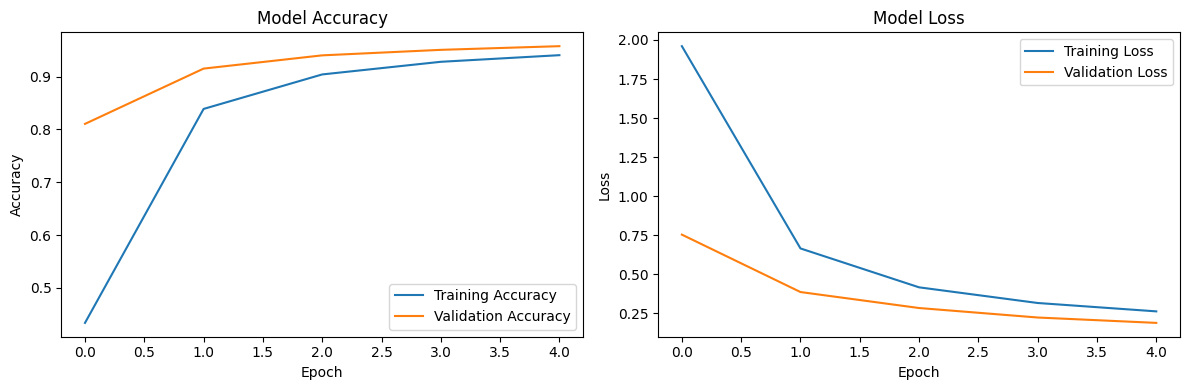

In [64]:
import matplotlib.pyplot as plt

# Graficar la precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Graficar la pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [65]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

# Imprimir las métricas obtenidas
print(f"Loss en el conjunto de prueba: {test_loss:.4f}")
print(f"Accuracy en el conjunto de prueba: {test_accuracy:.4f}")


477/477 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9593 - loss: 0.1815
Loss en el conjunto de prueba: 0.1899
Accuracy en el conjunto de prueba: 0.9574


477/477 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step
Informe de clasificación:
                         precision    recall  f1-score   support

                  Acoge       0.99      0.99      0.99       733
                Acuerdo       0.00      0.00      0.00        29
            Acumulación       0.00      0.00      0.00        20
             Admisibles       0.99      1.00      1.00      2297
      Agréguese A Tabla       1.00      1.00      1.00      1810
               Apercibe       0.00      0.00      0.00        92
              Archivado       0.00      0.00      0.00        47
          Art / Numeral       0.00      0.00      0.00        31
           Certifiquese       0.00      0.00      0.00        41
      Concede Apelación       0.99      1.00      0.99      1394
                     Cs       1.00      1.00      1.00      1295
            Dese Cuenta       0.86      0.98      0.91       447
         Evacua Informe       0.98      0.99      0.99      2045
        Fallo/Desest

c:\Users\kev_g\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kev_g\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kev_g\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

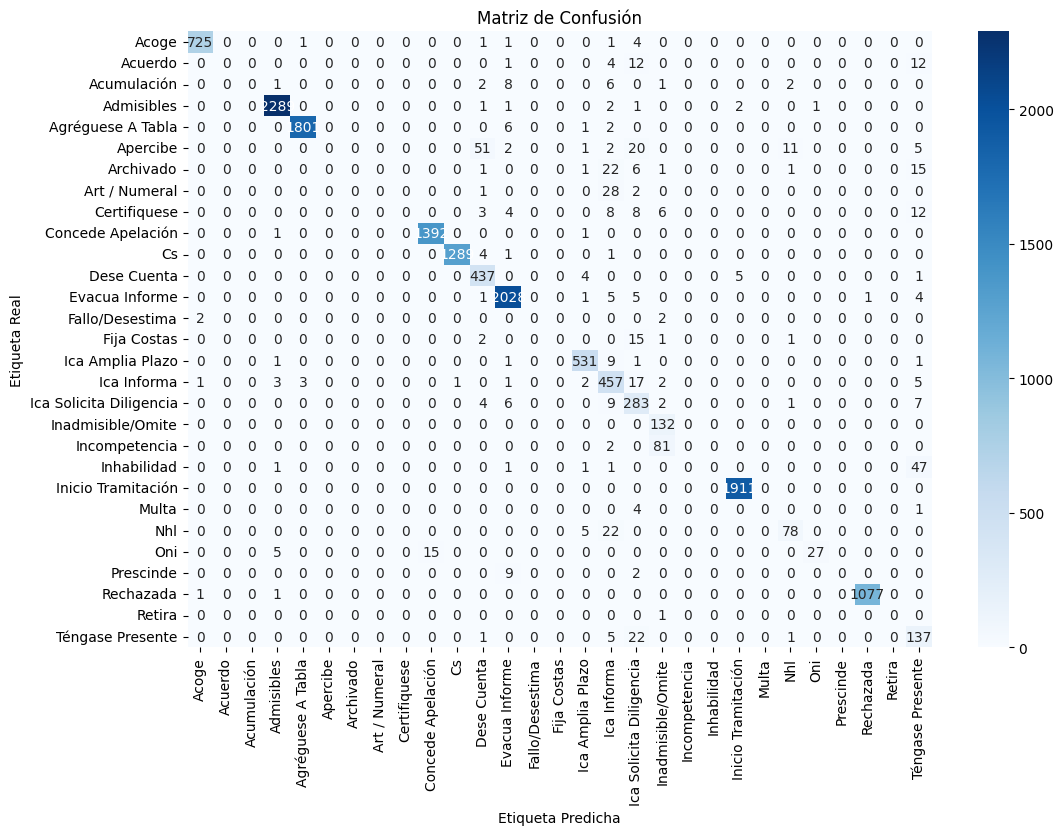

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predecir las probabilidades para el conjunto de prueba
y_pred_probs = model.predict(X_test)

# Convertir las probabilidades a clases predichas
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener las etiquetas reales
y_true = np.argmax(y_test, axis=1)

# Generar el informe de clasificación
print("Informe de clasificación:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Generar la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión')
plt.show()


In [69]:
# Definición del modelo
model = Sequential()

# Capa de Embedding
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_sequence_len))

# Capa LSTM
model.add(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

# Capa densa
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))

# Capa de salida
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compilación del modelo
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Resumen del modelo
model.summary()


c:\Users\kev_g\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [70]:
y_train_int = y_train.argmax(axis=1)  # De one-hot a entero


In [71]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_int), y=y_train_int)
class_weights_dict = dict(enumerate(class_weights))

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=10, batch_size=32, 
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 79s 70ms/step - accuracy: 0.1430 - loss: 3.4738 - val_accuracy: 0.5885 - val_loss: 1.9942 - learning_rate: 1.0000e-04
Epoch 2/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 77s 69ms/step - accuracy: 0.6214 - loss: 2.7926 - val_accuracy: 0.8897 - val_loss: 0.7095 - learning_rate: 1.0000e-04
Epoch 3/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 77s 70ms/step - accuracy: 0.7876 - loss: 2.3409 - val_accuracy: 0.9333 - val_loss: 0.3943 - learning_rate: 1.0000e-04
Epoch 4/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 77s 69ms/step - accuracy: 0.8322 - loss: 1.8799 - val_accuracy: 0.9581 - val_loss: 0.2677 - learning_rate: 1.0000e-04
Epoch 5/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 77s 69ms/step - accuracy: 0.8656 - loss: 1.4873 - val_accuracy: 0.9706 - val_loss: 0.2316 - learning_rate: 1.0000e-04
Epoch 6/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 78s 70ms/step - accuracy: 0.8858 - loss: 1.4638 - val_accuracy: 0.9625 - val_loss: 0.1966 - learning_rate: 1.0000e-04
Epoch 7/10
1112/1112 ━━━━━━━━━━━━━━━━━━━

477/477 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step
Informe de clasificación:
                         precision    recall  f1-score   support

                  Acoge       1.00      1.00      1.00       733
                Acuerdo       0.67      0.97      0.79        29
            Acumulación       0.11      0.95      0.19        20
             Admisibles       1.00      1.00      1.00      2297
      Agréguese A Tabla       1.00      0.99      1.00      1810
               Apercibe       0.76      0.91      0.83        92
              Archivado       0.83      0.91      0.87        47
          Art / Numeral       0.91      1.00      0.95        31
           Certifiquese       0.79      0.66      0.72        41
      Concede Apelación       1.00      1.00      1.00      1394
                     Cs       1.00      1.00      1.00      1295
            Dese Cuenta       0.99      0.96      0.97       447
         Evacua Informe       0.99      0.90      0.94      2045
        Fallo/Desest

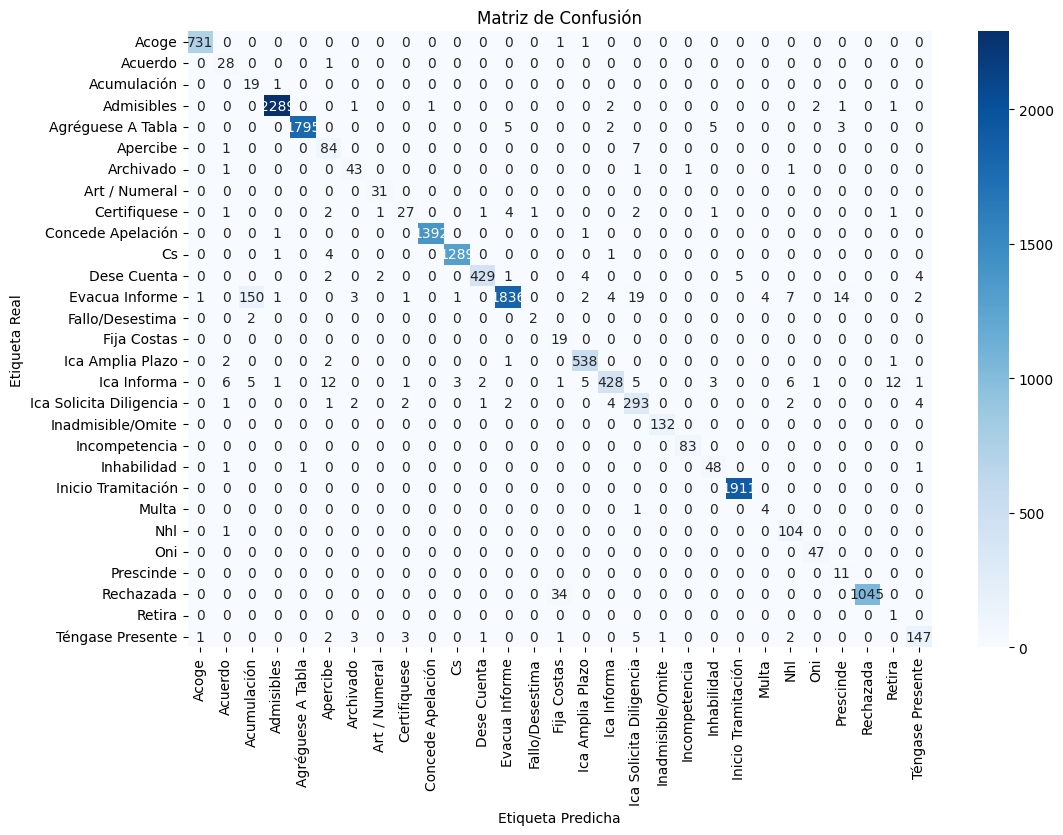

In [72]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predecir las probabilidades para el conjunto de prueba
y_pred_probs = model.predict(X_test)

# Convertir las probabilidades a clases predichas
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener las etiquetas reales
y_true = np.argmax(y_test, axis=1)

# Generar el informe de clasificación
print("Informe de clasificación:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Generar la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión')
plt.show()


In [75]:
df_csv['CLASIFICACION_CORRECTA'].value_counts()

CLASIFICACION_CORRECTA
Admisibles                 7608
Evacua Informe             6888
Inicio Tramitación         6360
Agréguese A Tabla          6099
Concede Apelación          4636
Cs                         4485
Rechazada                  3560
Acoge                      2349
Ica Amplia Plazo           1793
Ica Informa                1593
Dese Cuenta                1400
Ica Solicita Diligencia    1015
Téngase Presente            588
Inadmisible/Omite           453
Nhl                         371
Apercibe                    319
Incompetencia               269
Archivado                   191
Oni                         173
Inhabilidad                 125
Certifiquese                113
Art / Numeral               111
Acuerdo                      96
Acumulación                  67
Fija Costas                  64
Prescinde                    51
Fallo/Desestima              14
Multa                         9
Retira                        8
Name: count, dtype: int64

### Las clases con problemas son las siguientes:
- Acuerdo, Acumulación, Apercibe, Archivado, Certifiquese,  Fallo/Desestima, Fija Costas, Ica Solicita Diligencia, Inhabilidad, Multa, Nhl, Retira
Prescinde

In [79]:
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='pre')
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.2, random_state=42)
# 2. Convertir etiquetas de una codificación categórica (one-hot) a valores enteros
y_train_int = y_train.argmax(axis=1)  # De one-hot a entero

# 3. Aplicar SMOTE para generar datos sintéticos
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_int)

# 4. Volver a convertir las etiquetas generadas por SMOTE a one-hot encoding
y_train_resampled = to_categorical(y_train_resampled, num_classes=y_categorical.shape[1])

# Verificar los tamaños después de SMOTE
print(f"Tamaño original: {X_train.shape}, Tamaño después de SMOTE: {X_train_resampled.shape}")

Tamaño original: (40646, 163), Tamaño después de SMOTE: (175450, 163)


In [81]:
# Definición del modelo
model = Sequential()

# Capa de Embedding
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_sequence_len))

# Capa LSTM
model.add(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

# Capa densa
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

# Capa de salida
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compilación del modelo
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Resumen del modelo
model.summary()
history = model.fit(X_train_resampled, y_train_resampled, 
                    validation_data=(X_test, y_test), 
                    epochs=5, batch_size=32, 
                    callbacks=[early_stopping, reduce_lr])

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 372s 68ms/step - accuracy: 0.5098 - loss: 1.9270 - val_accuracy: 0.9775 - val_loss: 0.1560 - learning_rate: 1.0000e-04
Epoch 2/5
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 330s 60ms/step - accuracy: 0.8995 - loss: 0.4866 - val_accuracy: 0.9818 - val_loss: 0.1261 - learning_rate: 1.0000e-04
Epoch 3/5
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 324s 59ms/step - accuracy: 0.9162 - loss: 0.3858 - val_accuracy: 0.9850 - val_loss: 0.1023 - learning_rate: 1.0000e-04
Epoch 4/5
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 337s 61ms/step - accuracy: 0.9248 - loss: 0.3347 - val_accuracy: 0.9852 - val_loss: 0.0971 - learning_rate: 1.0000e-04
Epoch 5/5
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 376s 69ms/step - accuracy: 0.9298 - loss: 0.3080 - val_accuracy: 0.9867 - val_loss: 0.0921 - learning_rate: 1.0000e-04


318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
Informe de clasificación:
                         precision    recall  f1-score   support

                  Acoge       1.00      0.99      0.99       479
                Acuerdo       0.74      1.00      0.85        17
            Acumulación       0.70      1.00      0.82         7
             Admisibles       1.00      0.98      0.99      1558
      Agréguese A Tabla       1.00      0.99      1.00      1223
               Apercibe       0.91      0.98      0.95        54
              Archivado       1.00      0.90      0.95        31
          Art / Numeral       0.85      1.00      0.92        17
           Certifiquese       0.74      0.71      0.73        28
      Concede Apelación       1.00      1.00      1.00       937
                     Cs       1.00      0.99      0.99       874
            Dese Cuenta       0.99      0.98      0.98       286
         Evacua Informe       0.99      0.99      0.99      1343
        Fallo/Desesti

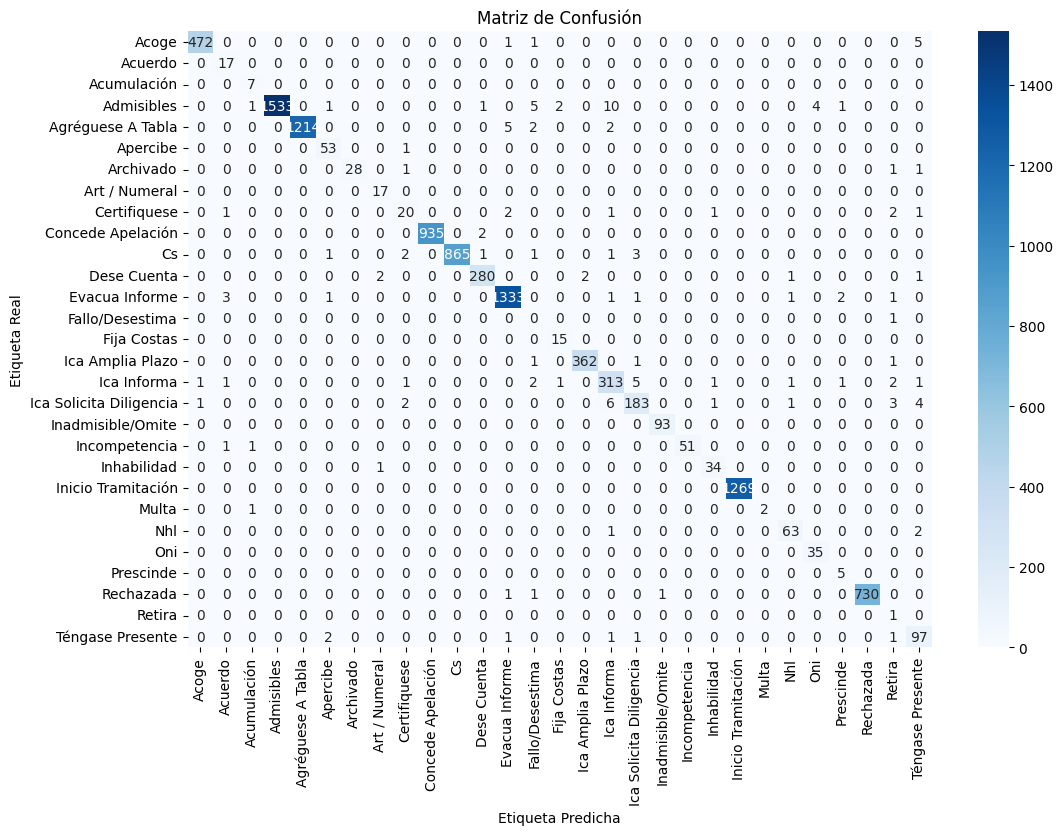

In [82]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predecir las probabilidades para el conjunto de prueba
y_pred_probs = model.predict(X_test)

# Convertir las probabilidades a clases predichas
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener las etiquetas reales
y_true = np.argmax(y_test, axis=1)

# Generar el informe de clasificación
print("Informe de clasificación:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Generar la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión')
plt.show()
